# Simulating and fitting a time varying source

## Prerequisites

- To understand how a single binned simulation works, please refer to [spectrum_simulation](../1D/spectrum_simulation.ipynb) [simulate_3d](../3D/simulate_3d.ipynb) for 1D and 3D simulations respectively.
- For details of light curve extraction using gammapy, refer to the two tutorials [light_curve](light_curve.ipynb) and [light_curve_flare](light_curve_flare.ipynb) 

## Context

Frequently, studies of variable sources (eg: decaying GRB light curves, AGN flares, etc) require time variable simulations. For most use cases, generating an event list is an overkill, and it suffices to use binned simulations using a temporal model.

**Objective: Simulate and fit a time decaying light curve of a source with CTA using the CTA 1DC response**

## Proposed approach

We will simulate 10 spectral datasets within given time intervals (Good Time Intervals) following a given spectral (a power law) and temporal profile (an exponential decay, with a decay time of 6 hr ). These are then analysed using the light curve estimator to obtain flux points. 

Modelling and fitting of lightcurves can be done either
- directly on the output of the `LighCurveEstimator` (at the DL5 level)
- fit the simulated datasets (at the DL4 level)

In summary, necessary steps are:

- Choose observation parameters including a list of `gammapy.data.GTI`
- Define temporal and spectral models from :ref:model-gallery as per science case
- Perform the simulation (in 1D or 3D)
- Extract the light curve from the reduced dataset as shown in [light curve notebook](light_curve.ipynb)
- Optionally, we show here how to fit the simulated datasets using a source model 


## Setup 

As usual, we'll start with some general imports...

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

import logging

log = logging.getLogger(__name__)

And some gammapy specific imports

In [2]:
from gammapy.data import Observation
from gammapy.irf import load_cta_irfs
from gammapy.datasets import SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    SkyModel,
)
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.data import observatory_locations

We first define our preferred time format:

In [3]:
TimeMapAxis.time_format = "iso"

## Simulating a light curve

We will simulate 10  spectra between 300 GeV and 10 TeV using an `PowerLawSpectralModel` and a `ExpDecayTemporalModel`. The important thing to note here is how to attach a different `GTI` to each dataset. Since we use spectrum datasets here, we will use a `RegionGeom`.

In [4]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [5]:
# bkg = irfs['bkg']

# print(bkg,'\n',
#       bkg.default_interp_kwargs,'\n',
#       bkg.default_unit,'\n',
#       bkg.fov_alignment,'\n',
#       'Has offset axis',bkg.has_offset_axis,'\n',
#       'Is_pointlike',bkg.is_pointlike,'\n',
#       bkg.required_axes,'\n',
#       bkg.tag,'\n',
#       bkg.unit,'\n',
#      )

# irfs['bkg'].peek()

In [6]:
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

geom = RegionGeom.create("galactic;circle(0, 0, 0.11)", axes=[energy_axis])

In [7]:
# Pointing position
pointing = SkyCoord(0.5, 0.5, unit="deg", frame="galactic")

Note that observations are usually conducted in  Wobble mode, in which the source is not in the center of the camera. This allows to have a symmetrical sky position from which background can be estimated.

In [8]:
# Define the source model: A combination of spectral and temporal model

gti_t0 = Time("2020-03-01")
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model = ExpDecayTemporalModel(t0="6 h", t_ref=gti_t0.mjd * u.d)

model_simu = SkyModel(
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="model-simu",
)

/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [9]:
# Look at the model
model_simu.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,int64,float64,float64,bool,bool,str1
spectral,index,3.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-11,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,6.0000e+00,h,0.000e+00,nan,nan,False,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,False,


Now, define the start and observation livetime wrt to the reference time, `gti_t0`

In [29]:
n_obs = 10

tstart = gti_t0 + [1, 2, 3, 5, 8, 10, 20, 22, 23, 24] * u.h
lvtm = [55, 25, 26, 40, 40, 50, 40, 52, 43, 47] * u.min

Now perform the simulations

In [148]:
from gammapy.utils.random import get_random_state
empty = SpectrumDataset.create(geom = geom,
                               energy_axis_true = energy_axis_true,
                               name = "try"
                              )

maker = SpectrumDatasetMaker(selection = ["exposure",
                                          "background",
                                          "edisp"
                                         ]
                            )

idx = 0
obs = Observation.create(pointing = pointing,
                         livetime = lvtm[idx],
                         tstart = tstart[idx],
                         irfs = irfs,
                         reference_time = gti_t0,
                         obs_id = idx,
                         location = observatory_locations["cta_south"]
                        )

# Let's compute precdicted background (constant)
dataset = maker.run(empty, obs)

# # Introduce Background fluctuation (Poisson)
# random_state = get_random_state('random-seed')

# data = np.nan_to_num(dataset.npred_background().data,
#                      copy = True,
#                      nan = 0.0,
#                      posinf = 0.0,
#                      neginf = 0.0
#                     )
# data = random_state.poisson(data)
# dataset.npred_background().data = data
# dataset.background = dataset.npred_background()
# print(dataset)

# Attach the Model: fix the Predicted Excess

dataset.models = model_simu

print(dataset.npred_signal().data)

# Simulate Counts from Poisson(Predicted Excess + Predicted Background)
# dataset.fake()

#print(dataset)


[[[299.95010833]]

 [[206.99122739]]

 [[104.07355607]]

 [[ 78.67716739]]

 [[ 45.14854923]]

 [[ 35.51594782]]

 [[ 18.67061877]]

 [[ 10.96310337]]

 [[  5.63137972]]]


In [150]:
print(datasets[0])

SpectrumDataset
---------------

  Name                            : dataset-0 

  Total counts                    : 775 
  Total background counts         : 20.32
  Total excess counts             : 754.68

  Predicted counts                : 825.94
  Predicted background counts     : 20.32
  Predicted excess counts         : 805.62

  Exposure min                    : 2.16e+08 m2 s
  Exposure max                    : 1.60e+10 m2 s

  Number of total bins            : 9 
  Number of fit bins              : 9 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -6135.73

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : ExpDecayTemporalModel
    Parameters:
      index     

In [31]:
datasets = Datasets()

empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="empty"
)

maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])


for idx in range(n_obs):
    obs = Observation.create(
        pointing=pointing,
        livetime=lvtm[idx],
        tstart=tstart[idx],
        irfs=irfs,
        reference_time=gti_t0,
        obs_id=idx,
        location=observatory_locations["cta_south"],
    )
    empty_i = empty.copy(name=f"dataset-{idx}")
    dataset = maker.run(empty_i, obs)
    dataset.models = model_simu
    dataset.fake()
    datasets.append(dataset)

The reduced datasets have been successfully simulated. Let's take a quick look into our datasets.

In [33]:
datasets.info_table()

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str9,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
dataset-0,775,754.6812133789062,64.301480445193,20.318769454956055,20.318769738078117,20.318769454956055,nan,216137904.0,16025275392.0,3299.9999999999973,3300.0,0.23484848484848506,0.006157202865138204,0.22869127678148693,9,9,cash,nan
dataset-1,323,313.764195792777,40.84997380572502,9.235804207223023,332.14961280981925,9.235804207223023,322.9138086025962,98244500.9355637,7284216297.312288,1500.0000000000036,1500.0000000000036,0.21533333333333282,0.006157202804815334,0.2091761305285175,9,9,cash,-1967.150323980137
dataset-2,283,273.39476362448806,36.98738784067027,9.605236375511943,293.4896025844399,9.605236375511943,283.884366208928,102174280.97298624,7575584949.204779,1560.0000000000036,1560.0000000000036,0.181410256410256,0.006157202804815334,0.17525305360544066,9,9,cash,-1666.4020420250047
dataset-3,346,331.2227132684432,38.98295795892008,14.777286731556803,321.78385941878605,14.777286731556803,307.0065726872292,157191201.49690154,11654746075.699633,2400.0,2400.0,0.14416666666666667,0.006157202804815335,0.13800946386185134,9,9,cash,-2185.9149551508117
dataset-4,194,179.2227132684432,25.309367956996965,14.777286731556803,200.98618579965654,14.777286731556803,186.2088990680997,157191201.49690154,11654746075.699633,2400.0,2400.0,0.08083333333333333,0.006157202804815335,0.074676130528518,9,9,cash,-980.9069307626726
dataset-5,195,176.528391585554,23.79246612303794,18.471608414446003,182.99944272932842,18.471608414446003,164.5278343148824,196489001.87112692,14568432594.62454,3000.0,3000.0,0.065,0.006157202804815334,0.05884279719518467,9,9,cash,-1033.342878153287
dataset-6,28,13.222713268443197,3.056944883537156,14.777286731556803,39.97792082811601,14.777286731556803,25.20063409655921,157191201.49690154,11654746075.699633,2400.0,2400.0,0.011666666666666667,0.006157202804815335,0.0055094638618513325,9,9,cash,-45.12897847782046
dataset-7,44,24.789527248976157,4.832136350439279,19.210472751023843,42.30482881204877,19.210472751023843,23.094356061024925,204348561.945972,15151169898.409523,3120.0,3120.0,0.014102564102564103,0.006157202804815335,0.007945361297748768,9,9,cash,-105.55590939438575


## Extract the lightcurve

This section uses standard light curve estimation tools for a 1D extraction. Only a spectral model needs to be defined in this case. Since the estimator returns the integrated flux separately for each time bin, the temporal model need not be accounted for at this stage. We extract the lightcurve in 3 energy binsç

In [14]:
# Define the model:
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit = SkyModel(spectral_model=spectral_model, name="model-fit")

In [15]:
# Attach model to all datasets
datasets.models = model_fit

In [16]:
%%time
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.3, 0.6, 1.0, 10] * u.TeV,
    source="model-fit",
    selection_optional=["ul"],
)
lc_1d = lc_maker_1d.run(datasets)

CPU times: user 10.9 s, sys: 15.1 ms, total: 10.9 s
Wall time: 10.9 s


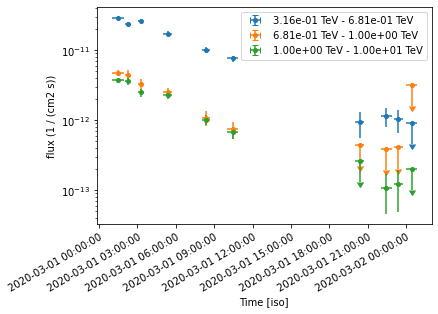

In [17]:
ax = lc_1d.plot(marker="o", axis_name="time", sed_type="flux")

## Fitting temporal models
We have the reconstructed lightcurve at this point. Now we want to fit a profile to the obtained light curves, using a joint fitting across the different datasets, while simultaneously minimising across the temporal model parameters as well. The temporal models can be applied 

- directly on the obtained lightcurve
- on the simulated datasets

### Fitting the obtained light curve

The fitting will proceed through a joint fit of the flux points. First, we need to obtain a set of `FluxPointDatasets`, one for each time bin

In [18]:
## Create the datasets by iterating over the returned lightcurve
datasets = Datasets()

for idx, fp in enumerate(lc_1d.iter_by_axis(axis_name="time")):
    dataset = FluxPointsDataset(data=fp, name=f"time-bin-{idx}")
    datasets.append(dataset)

We will fit the amplitude, spectral index and the decay time scale. Note that `t_ref` should be fixed by default for the `ExpDecayTemporalModel`. 

In [19]:
# Define the model:
spectral_model1 = PowerLawSpectralModel(
    index=2.0, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model1 = ExpDecayTemporalModel(t0="10 h", t_ref=gti_t0.mjd * u.d)

model = SkyModel(
    spectral_model=spectral_model1,
    temporal_model=temporal_model1,
    name="model-test",
)

/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [20]:
datasets.models = model

In [21]:
%%time
# Do a joint fit
fit = Fit()
result = fit.run(datasets=datasets)

CPU times: user 8.62 s, sys: 12.2 ms, total: 8.63 s
Wall time: 8.64 s


/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Now let's plot model and data. We plot only the normalisation of the temporal model in relative units for one particular energy range

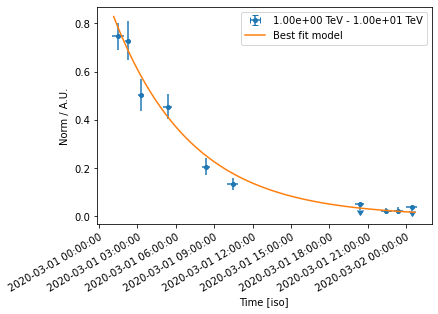

In [22]:
lc_1TeV_10TeV = lc_1d.slice_by_idx({"energy": slice(2, 3)})
ax = lc_1TeV_10TeV.plot(sed_type="norm", axis_name="time")

time_range = lc_1TeV_10TeV.geom.axes["time"].time_bounds
temporal_model1.plot(ax=ax, time_range=time_range, label="Best fit model")

ax.set_yscale("linear")
plt.legend()

### Fit the datasets

Here, we apply the models directly to the simulated datasets.

For modelling and fitting more complex flares, you should attach the relevant model to each group of `datasets`. The parameters of a model in a given group of dataset will be tied. For more details on joint fitting in gammapy, see [here](../2D/modeling_2D.ipynb).

In [23]:
# Define the model:
spectral_model2 = PowerLawSpectralModel(
    index=2.0, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model2 = ExpDecayTemporalModel(t0="10 h", t_ref=gti_t0.mjd * u.d)

model2 = SkyModel(
    spectral_model=spectral_model2,
    temporal_model=temporal_model2,
    name="model-test2",
)

/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [24]:
model2.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,int64,float64,float64,bool,bool,str1
spectral,index,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,1.0000e+01,h,0.000e+00,nan,nan,False,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,False,


In [25]:
datasets.models = model2

In [26]:
%%time
# Do a joint fit
fit = Fit()
result = fit.run(datasets=datasets)

CPU times: user 8.95 s, sys: 5.2 ms, total: 8.96 s
Wall time: 8.96 s


/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [27]:
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,3.0243e+00,,2.844e-02,nan,nan,False,False,
spectral,amplitude,9.6342e-12,cm-2 s-1 TeV-1,3.302e-13,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,6.0545e+00,h,2.285e-01,nan,nan,False,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,False,


We see that the fitted parameters are consistent between fitting flux points and datasets, and match well with the simulated ones

## Exercises

1. Re-do the analysis with `MapDataset` instead of `SpectralDataset`
2. Model the flare of PKS 2155-304 which you obtained using the [light curve flare tutorial](light_curve_flare.ipynb). Use a combination of a Gaussian and Exponential flare profiles, and fit using `scipy.optimize.curve_fit`
3. Do a joint fitting of the datasets.

In [141]:
# from gammapy.maps import Map
# import logging
# import numpy as np
# from astropy.coordinates import Angle, SkyOffsetFrame
# from astropy.table import Table
# from gammapy.irf import EDispMap, FoVAlignment, PSFMap
# from gammapy.maps import Map, RegionNDMap
# from gammapy.modeling.models import PowerLawSpectralModel
# from gammapy.stats import WStatCountsStatistic
# from gammapy.utils.coordinates import sky_to_fov
# from gammapy.utils.regions import compound_region_to_regions

# def make_map_background_irf(pointing, ontime, bkg, geom, oversampling=None, use_region_center=True):

#     coords = {"energy": geom.axes["energy"].edges.reshape((-1, 1, 1))}

#     image_geom = geom.to_image()

#     d_omega = image_geom.solid_angle()

#     map_coord = image_geom.get_coord()

#     sky_coord = map_coord.skycoord

    
#     # Create OffsetFrame
#     frame = SkyOffsetFrame(origin = pointing.radec)
#     pseudo_fov_coord = sky_coord.transform_to(frame)
#     fov_lon = pseudo_fov_coord.lon
#     fov_lat = pseudo_fov_coord.lat

#     coords["fov_lon"] = fov_lon
#     coords["fov_lat"] = fov_lat

#     bkg_de = bkg.integrate_log_log(**coords, axis_name="energy")
    
#     #print(bkg_de)
#     #print(bkg_de * d_omega * ontime)
#     data = (bkg_de * d_omega * ontime).to_value("")
#     #print(data)

#     bkg_map = Map.from_geom(geom, data=data)

#     return bkg_map

# a = make_map_background_irf(pointing = obs.fixed_pointing_info,
#                             ontime = obs.observation_time_duration,
#                             bkg = obs.bkg,
#                             geom = geom,
#                             oversampling = maker.background_oversampling,
#                             use_region_center = getattr(maker, "use_region_center", True)
#                            )
# a.data